In [1]:
import huggingface_hub

In [2]:
!pip install bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 3.3 MB/s eta 0:00:00


In [3]:
from google.colab import userdata
token = userdata.get('HF_TOKEN')

In [4]:
from huggingface_hub import login
login(token)
print('Successful login')

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successful login


## Ready training data


{"paragraph" : "data...."} in jsonl files
max_length restricted to 256 characters to avoid out of memory errors

In [5]:
!unzip selected_data_txt.zip

Archive:  selected_data_txt.zip
   creating: selected_data_txt/
  inflating: selected_data_txt/ADMINISTRATIVE_LAW_FF.txt  
  inflating: selected_data_txt/ADVOCATES_ACT_f.txt  
  inflating: selected_data_txt/ANCIENT_LAW _F.txt  
  inflating: selected_data_txt/ARBITRATION_And_CONCILIATION.txt  
  inflating: selected_data_txt/CIVIL_PROCEDURE_CODE_FINAL2012.txt  
  inflating: selected_data_txt/COMPANY_LAW.txt  
  inflating: selected_data_txt/CONSTITUTION_OF_INDIA.txt  
  inflating: selected_data_txt/CONTRACT-Specific_ReliefAct.txt  
  inflating: selected_data_txt/CONTRACT_Act_F.txt  
  inflating: selected_data_txt/CRIMINAL_PROCEDURE_CODE.txt  
 extracting: selected_data_txt/EVIDENCE_ACT.txt  
  inflating: selected_data_txt/HINDU_LAW_2012.txt  
  inflating: selected_data_txt/INDEMNITY_GUARANTEE_BAILMENT.txt  
  inflating: selected_data_txt/INDIAN_CONSTITUTIONAL_HISTORY.txt  
  inflating: selected_data_txt/INDIAN_LEGAL_HISTORY.txt  
  inflating: selected_data_txt/INDIAN_PENAL_CODE.txt  
  in

In [6]:
import os
import json

# Paths to the folder and output files
input_folder = "selected_data_txt"
train_output_file = "data.jsonl"
eval_output_file = "data_validation.jsonl"

# Function to process each note into 256-character paragraphs
def process_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read().strip().replace('\n', ' ')
        paragraphs = []
        while len(content) > 0:
            paragraphs.append({"paragraph": content[:256]})
            content = content[256:].strip()
        return paragraphs

# Split data into training and evaluation sets (e.g., 80% training, 20% evaluation)
def split_data(data, train_ratio=0.8):
    split_point = int(len(data) * train_ratio)
    return data[:split_point], data[split_point:]

# Process all .txt files in the folder
all_paragraphs = []
for filename in os.listdir(input_folder):
    if filename.endswith(".txt"):
        file_path = os.path.join(input_folder, filename)
        all_paragraphs.extend(process_file(file_path))

# Split the data into training and evaluation datasets
train_data, eval_data = split_data(all_paragraphs)

# Write train and eval datasets to their respective jsonl files
with open(train_output_file, 'w', encoding='utf-8') as train_file:
    for entry in train_data:
        json.dump(entry, train_file)
        train_file.write('\n')

with open(eval_output_file, 'w', encoding='utf-8') as eval_file:
    for entry in eval_data:
        json.dump(entry, eval_file)
        eval_file.write('\n')

print(f"Processed {len(train_data)} training paragraphs and {len(eval_data)} evaluation paragraphs.")


Processed 13038 training paragraphs and 3260 evaluation paragraphs.


## Load the model and train

Mistral 7b instruct v0.1 base model used

In [28]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-Instruct-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/25.1k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

In [8]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [9]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='data.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='data_validation.jsonl', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [10]:
def formatting_func(example):
    text = f"### The following is a note in a Law Textbook: {example['paragraph']}"
    return text

### Tokenization

In [11]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))


tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map:   0%|          | 0/13038 [00:00<?, ? examples/s]

Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

16298


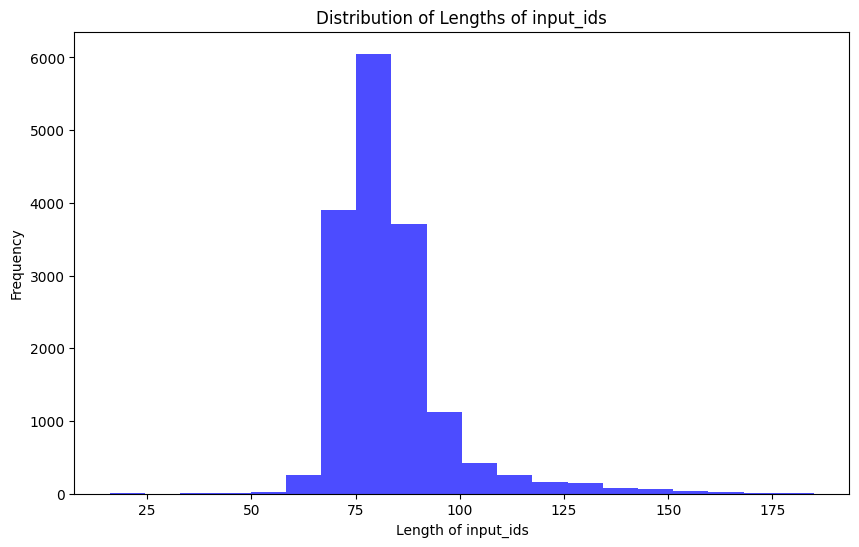

In [13]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [14]:
max_length = 128 # This was an appropriate max length for our dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [15]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Map:   0%|          | 0/13038 [00:00<?, ? examples/s]

Map:   0%|          | 0/3260 [00:00<?, ? examples/s]

In [16]:
print(tokenized_train_dataset[1]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 774, 415, 2296, 349, 264, 5039, 297, 264, 5802, 7379, 3521, 28747, 307, 4485, 28723, 2287, 28750, 28723, 16725, 4495, 28723, 2287, 28770, 28723, 413, 293, 4485, 4950, 1799, 28723, 260, 398, 8202, 2468, 567, 12165, 1197, 259, 398, 3122, 1422, 567, 9187, 387, 763, 1422, 259, 398, 2332, 8608, 413, 293, 4485, 259, 398, 413, 293, 1116, 302, 24581, 355, 28781, 28723, 351, 2804, 302, 4868, 364, 5549, 413, 293, 4485, 28723, 2287, 28782, 28723, 3981, 2489, 495, 28705, 413, 293, 15295, 14515, 28723, 28705, 7973, 628, 28705, 413, 293, 4485, 28723, 2287, 28784, 28723, 1337, 2]


16298


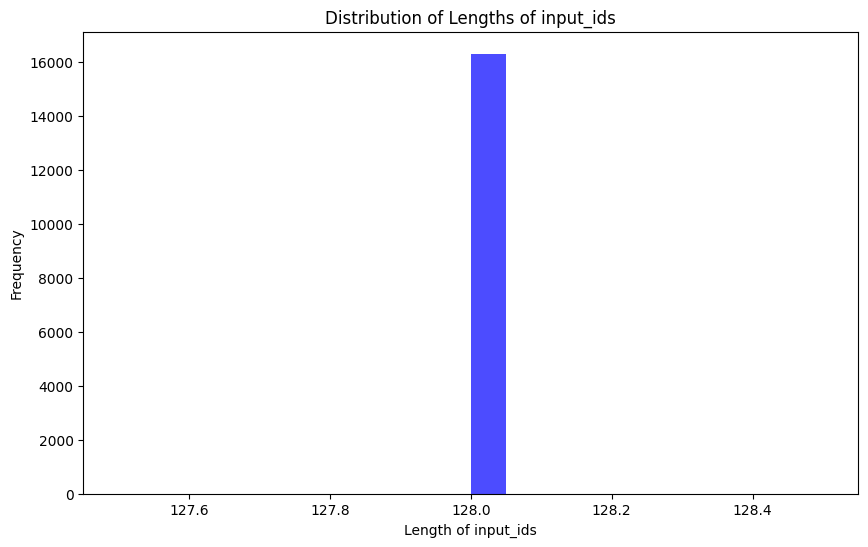

In [17]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)
# check is all of max_len

In [18]:
!pip install peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.4/296.4 kB 6.5 MB/s eta 0:00:00


## Set up LoRA

In [30]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [31]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [32]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

In [33]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)


trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


In [23]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
                (lora_magnitude_vector): ModuleDict()
              )
              (k

## Training

In [35]:
from accelerate import Accelerator
accelerator = Accelerator()
model = accelerator.prepare(model)


In [36]:
import transformers
from datetime import datetime

project = "journal-finetune"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=25,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=25,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=25,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


ValueError: You cannot perform fine-tuning on purely quantized models. Please attach trainable adapters on top of the quantized model to correctly perform fine-tuning. Please see: https://huggingface.co/docs/transformers/peft for more details